In [1]:
import pandas as pd
import numpy as np
import re
import string
import os
import json
from bidict import bidict
import pickle
import json
import random
import errno
from ggplot import aes, geom_point, geom_line, scale_y_continuous, xlab, ylab, facet_grid, facet_wrap, facets, ggplot, theme_gray
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.externals import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from math import ceil
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import itertools

/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted", 20))

In [3]:
def get_subsequences(sequences):
    sub_seqs = []    
    for seq in sequences:
        for i in range(2,len(seq)):
            sub_seqs.append(seq[:i])
    return sub_seqs

In [4]:
def save_data(path, file_name, model, x, targets):
    
    if not os.path.exists(os.path.join(path)):
        print("Attempting to create directory...")
        try:
            os.makedirs(os.path.join(path))
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
    print(f"Saving predictions in {path}...")

    preds = model.predict_proba(x)
    np.save(os.path.join(path, file_name + "-preds_reduced7000.npy"), preds)
    np.save(os.path.join(path, file_name + "-targets_reduced7000.npy"), targets)

In [5]:
def apply_stemming(data):
    """data is a list of sequences"""
    
    stemmer = SnowballStemmer('english')
    pattrn = re.compile(r"[-/,\.\\\s_]")
    
    output = []
    
    for sequence in data:
        stemmed_seq = []        
        for title in sequence:
            stemmed = ""            
            for token in re.split(pattrn, title):
                if stemmed:
                    stemmed += " " + stemmer.stem(token)
                else:
                    stemmed += stemmer.stem(token)
            stemmed_seq.append(stemmed)
            
        output.append(stemmed_seq)

    return [" ".join(seq) for seq in output]

In [6]:
def get_data_sets(json_path, tokenize_titles=True, use_stemmer=True, use_sub_seq=False):
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    title_id = bidict(data["title_to_id"])
    train_data = data["train_data"]
    test_data = data["test_data"]
    
    if use_sub_seq:
        train_data = get_subsequences(train_data)
        #test_data = get_subsequences(test_data)
    
    
    if tokenize_titles:
        train_seq = [[title_id.inv[i] for i in title_seq[1][:-1]] for title_seq in train_data]
        test_seq = [[title_id.inv[i] for i in title_seq[1][:-1]] for title_seq in test_data]
    else:
        # replace whitespace by underscore to prevent breaking up multi word job titles
        train_seq = [[str(i) for i in title_seq[1][:-1]] for title_seq in train_data]
        test_seq = [[str(i) for i in title_seq[1][:-1]]  for title_seq in test_data]
    
    train_targets = [seq[1][-1] for seq in train_data]
    test_targets = [seq[1][-1] for seq in test_data]
    
    if tokenize_titles and not use_stemmer:
        train_text = [" ".join(title_seq).replace("_", " ") for title_seq in train_seq]  
        test_text = [" ".join(title_seq).replace("_", " ") for title_seq in test_seq]
    elif tokenize_titles and use_stemmer:
        train_text = apply_stemming(train_seq)
        test_text = apply_stemming(test_seq)
    else:
        train_text = [" ".join(title_seq) for title_seq in train_seq]  
        test_text = [" ".join(title_seq) for title_seq in test_seq]
        
    return train_text, train_targets, test_text, test_targets

In [7]:
def run_model(model, X_train, train_targets, X_test, test_targets):
    # Train
    print(f"Training Naive Bayes...")
    #batches = np.array_split(X_train.toarray(), 100)
    #target_batches = np.array_split(train_targets, 100)
    #classes = sorted(list(set(train_targets + test_targets)))
    #i = 0
    model.fit(X_train, train_targets)
    #for batch, targets in zip(batches, target_batches):
    #    if i == 0:
    #        model.partial_fit(batch, targets, classes=classes)
    #    else:
    #        model.partial_fit(batch, targets)

    # Test
    print("Running trained model on test dataset")
    predicted = model.predict(X_test)
    acc = np.mean(predicted == test_targets)

    print("Model Accuracy: " + str(acc))
    
    return model

In [8]:
def run_experiment(data_path, tokenized_titles=False, use_stemmer=False, tf_idf=False, sub_seq=False):
    
    # Fetch and preprocess data
    train, train_targets, test, test_targets = get_data_sets(data_path, tokenized_titles, use_stemmer, sub_seq)
    
    # Construct Models
    multi_nb = MultinomialNB()
    nb = BernoulliNB()
    
    # Construct vectorizer
    if tokenized_titles:
        sw = stopwords.words('english')    
        vect = CountVectorizer(stop_words=sw)
        vect = vect.fit(train + test)
    else:
        vect = CountVectorizer(token_pattern=r"\b\d+\b")
        vect = vect.fit(train + test)       
    
    print(f"Vocab Size: {len(vect.vocabulary_)}")
    
    # Construct document matices
    X_train = vect.transform(train)
    X_test = vect.transform(test)
    
    # Run Models
    multi_nb = run_model(multi_nb, X_train, train_targets, X_test, test_targets)
    nb = run_model(nb, X_train, train_targets, X_test, test_targets)

    return multi_nb, nb, X_train, X_test, train_targets, test_targets

In [9]:
def get_preds(model, X, targets):
    preds = model.predict_proba(x, targets)
    return preds

def top_k_acc(preds, targets, k=1):
    sorted_args = (-preds).argsort(axis=1)[:,:k]
    tt = np.tile(targets, (k,1)).T
    acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def print_top_k_accs(model, X_test, targets):
    print(f"acc: {top_k_acc(model, X_test, targets, k=1)[0]*100:.2f}")
    print(f"top 2: {top_k_acc(model, X_test, targets, k=2)[0]*100:.2f}")
    print(f"top 3: {top_k_acc(model, X_test, targets, k=3)[0]*100:.2f}")
    print(f"top 4: {top_k_acc(model, X_test, targets, k=4)[0]*100:.2f}")
    print(f"top 5: {top_k_acc(model, X_test, targets, k=5)[0]*100:.2f}")

In [10]:
reduced7000_path = "/data/rali7/Tmp/solimanz/data/datasets/reduced7000/jobid/data.json"   
top550_path = "/data/rali7/Tmp/solimanz/data/datasets/top550/jobid/data.json"   

In [11]:
model_names = ["mult_nb_bow_no_stem",
               "mult_nb_bow_stem",
               "bern_nb_bow_no_stem",
               "bern_nb_bow_stem",
               "mult_nb_titles",
               "bern_nb_titles"]

In [12]:
top550_models = {k: None for k in model_names}

In [13]:
accs = {
    'dataset': [],
    'top_k': [],
    'model': [],
    'accuracy': []
}

In [14]:
def add_to_dict(accs, preds, targets, dataset, model):
    for k in range(1, 11):
        accs['dataset'].append(dataset)
        accs['top_k'].append(k)
        accs['model'].append(model)
        accs['accuracy'].append(top_k_acc(preds, targets, k))

# Top 550 Data Set

## Tokenized Job Titles

### Without Stemming

In [31]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(top550_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=False,
                                                                            sub_seq=False)

add_to_dict(accs, multi_nb.predict_proba(X_test), test_targets, '550_titles', "mult_nb_bow_no_stem")
add_to_dict(accs, nb.predict_proba(X_test), test_targets, '550_titles', "bern_nb_bow_no_stem")

top550_models["mult_nb_bow_no_stem"] = multi_nb.predict_proba(X_test)
top550_models["bern_nb_bow_no_stem"] = nb.predict_proba(X_test)

Vocab Size: 326
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3084449235106339
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.287550267401849


### With Stemming

In [32]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(top550_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=True,
                                                                           sub_seq=False)

add_to_dict(accs, multi_nb.predict_proba(X_test), test_targets, '550_titles', "mult_nb_bow_stem")
add_to_dict(accs, nb.predict_proba(X_test), test_targets, '550_titles', "bern_nb_bow_stem")
top550_models["mult_nb_bow_stem"] = multi_nb.predict_proba(X_test)
top550_models["bern_nb_bow_stem"] = nb.predict_proba(X_test)

Vocab Size: 299
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.30757431283943454
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.2869284026367066


## Use Full Job Titles

In [33]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(top550_path, 
                                                                            tokenized_titles=False, 
                                                                            use_stemmer=False,
                                                                            sub_seq=False)

add_to_dict(accs, multi_nb.predict_proba(X_test), test_targets, '550_titles', "mult_nb_titles")
add_to_dict(accs, nb.predict_proba(X_test), test_targets, '550_titles', "bern_nb_titles")

np.save("/data/rali7/Tmp/solimanz/data/nb_preds/multi_nb_550.npy", multi_nb.predict_proba(X_test))

top550_models["mult_nb_titles"] = multi_nb.predict_proba(X_test)
top550_models["bern_nb_titles"] = nb.predict_proba(X_test)

Vocab Size: 551
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3331122258612827
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.27851249948177936


# Reduced 7000 Data Set

In [34]:
reduced7k_models = {k: None for k in model_names}

## Tokenized Job Titles

### Without Stemming

In [35]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(reduced7000_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=False,
                                                                            sub_seq=False)
add_to_dict(accs, multi_nb.predict_proba(X_test), test_targets, 'reduced7k', "mult_nb_bow_no_stem")
add_to_dict(accs, nb.predict_proba(X_test), test_targets, 'reduced7k', "bern_nb_bow_no_stem")

reduced7k_models["mult_nb_bow_no_stem"] = multi_nb.predict_proba(X_test)
reduced7k_models["bern_nb_bow_no_stem"] = nb.predict_proba(X_test)

Vocab Size: 1842
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.15055406042451114
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.12900030433044318


### With Stemming

In [ ]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(reduced7000_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=True,
                                                                            sub_seq=False)

add_to_dict(accs, multi_nb.predict_proba(X_test), test_targets, 'reduced7k', "mult_nb_bow_stem")
add_to_dict(accs, nb.predict_proba(X_test), test_targets, 'reduced7k', "bern_nb_bow_stem")

reduced7k_models["mult_nb_bow_stem"] = multi_nb.predict_proba(X_test)
reduced7k_models["bern_nb_bow_stem"] = nb.predict_proba(X_test)

Vocab Size: 1634
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.14914578621681457
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.12879145010472548


## Use Full Job Titles

In [ ]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(reduced7000_path, 
                                                                            tokenized_titles=False, 
                                                                            use_stemmer=False,
                                                                            sub_seq=False)
add_to_dict(accs, multi_nb.predict_proba(X_test), test_targets, 'reduced7k', "mult_nb_titles")
add_to_dict(accs, nb.predict_proba(X_test), test_targets, 'reduced7k', "bern_nb_titles")
np.save("/data/rali7/Tmp/solimanz/data/nb_preds/multi_nb_7k.npy", multi_nb.predict_proba(X_test))
reduced7k_models["mult_nb_titles"] = multi_nb.predict_proba(X_test)
reduced7k_models["bern_nb_titles"] = nb.predict_proba(X_test)

Vocab Size: 7040
Training Naive Bayes...
Running trained model on test dataset


In [45]:
with open('/data/rali7/Tmp/solimanz/data/pickles/nb_accs.pkl', 'wb') as f:
    pickle.dump(accs, f)

#with open('/data/rali7/Tmp/solimanz/data/pickles/nb_res550.pkl', 'wb') as f:
#    pickle.dump(top550_models, f)
#with open('/data/rali7/Tmp/solimanz/data/pickles/nb_res7k.pkl', 'wb') as f:
#    pickle.dump(reduced7k_models, f)

## Visualization

In [7]:
with open('/data/rali7/Tmp/solimanz/data/pickles/nb_accs.pkl', 'rb') as f:
    accs = pickle.load(f)

In [39]:
path550 = "/data/rali7/Tmp/solimanz/data/datasets/top550/"
path7k = "/data/rali7/Tmp/solimanz/data/datasets/reduced7000/"

# Load data dicts
with open(os.path.join(path550, "jobid", "data.json"), "r") as f:
    data550 = json.load(f)
with open(os.path.join(path7k, "jobid", "data.json"), "r") as f:
    data7k = json.load(f)

targets550 = [d[1][-1] for d in data550['test_data']]
targets7k = [d[1][-1] for d in data7k['test_data']]

In [40]:
def get_dataframe(res, targets):
    ks = list(range(1,11))
    #df_dict = {"model": [], "acc": [], "top_2_acc": [], "top_3_acc": [], "top_4_acc": [], "top_5_acc": []}
    df_dict = {"model": [], "top_k": [], "value": []}

    for name, preds in res.items():
        for k in ks:
            df_dict["model"].append(name)
            df_dict["top_k"].append(k)
            df_dict["value"].append(round(top_k_acc(preds, targets, k), 5)*100)
    return pd.DataFrame(df_dict)

In [43]:
df550 = get_dataframe(top550_models, targets550)
df7k = get_dataframe(reduced7k_models, targets7k)

KeyboardInterrupt: 

In [ ]:
df["top_k"] = df["top_k"].apply(lambda x: f"Top {x} accuracy")

In [46]:
accs_df = pd.DataFrame(accs)

In [47]:
p = ggplot(aes(x='top_k', y='accuracy', color='model'), data=accs_df) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ facet_wrap('dataset', nrow=1, ncol=2) \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \

In [48]:
accs550 = accs_df[accs_df.dataset == '550_titles']
accs7k = accs_df[accs_df.dataset == 'reduced7k']

Text(0.5,1,'7k Titles Dataset')

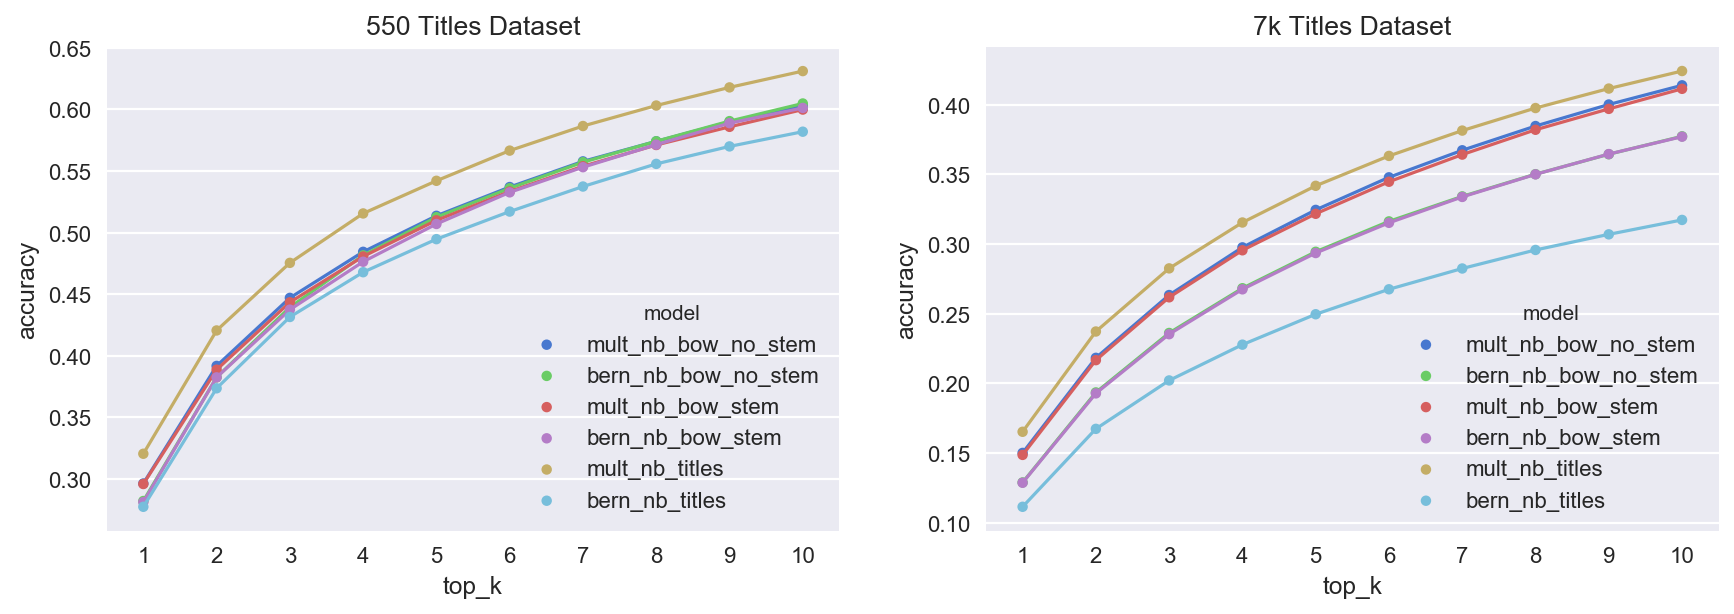

In [49]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
sns.pointplot(x='top_k', y='accuracy', hue='model', data=accs550, ax=ax[0])
sns.pointplot(x='top_k', y='accuracy', hue='model', data=accs7k, ax=ax[1])
ax[0].set_title('550 Titles Dataset')
ax[1].set_title('7k Titles Dataset')

In [50]:
fig.savefig('../../../Dropbox/thesis/thesis/images/nb_res.png', dpi=180, facecolor=fig.get_facecolor())